In [1]:
from IPython.display import display, HTML
import pandas as pd
import math
import datetime
import json
import requests
import numpy as np
import re
import jellyfish as jf
import geocoder
import time
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import re
import matplotlib.pyplot as plt
import subprocess
import os.path
from subprocess import PIPE,Popen
from collections import defaultdict
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
numberAttributes = 12

In [3]:
dirty = pd.read_csv("/home/felix/BlackOak/List_A/inputDB.csv")
clean = pd.read_csv("/home/felix/BlackOak/List_A/groundDB.csv", dtype={'SSN': object, 'ZIP': object})

In [4]:
distinct_values_per_column = []
for column in range(len(dirty.columns)):
    distinct_values_per_column.append(dict())

max_length = [0.0] * len(dirty.columns)
sum_length = np.array([0] * len(dirty.columns))
N = len(dirty)

for index, row in dirty.iterrows():
    for column in range(len(dirty.columns)):
        value = row[dirty.columns[column]]
        distinct_values_per_column[column][value] = distinct_values_per_column[column].get(value, 0) + 1

        
        max_length[column] = max (max_length[column], len(str(value)))
        sum_length[column] += len(str(value))
avg_length = sum_length / float(N)

for column in range(len(dirty.columns)):
    for key, value in distinct_values_per_column[column].iteritems():
        distinct_values_per_column[column][key] = value / float(N)

In [5]:
print max_length

[7, 13, 13, 21, 44, 21, 17, 29, 26, 41, 11, 9]


In [6]:
number_distinct_values_per_column = []
for column in range(len(dirty.columns)):
    number_distinct_values_per_column.append(len(distinct_values_per_column[column]))
print number_distinct_values_per_column

[94306, 15048, 681, 31917, 84228, 12695, 5070, 18825, 14558, 9735, 47358, 13608]


In [7]:
dirty.head()

,RecID(String),FirstName(String),MiddleName(String),LastName(String),Address(String),City(String),State(String),ZIP(String),POBox(String),POCityStateZip(String),SSN(String),DOB(String)
0,A904694,christine,NaN,urias,5404 ROCKLAND DR,pearland,tx,77584,NaN,NaN,166-91-0767,NaN
1,A904695,RICHARD,S,STOKES,2384 MOUNTAIN PINE RD,Hot,Springs,Ar 7191,NaN,NaN,NaN,4/12/72
2,A904696,michelle,NaN,daughtry,2301 plumeria lane,Palmdale,Ca,93551,PO MBOX 901243,"palmdale, ca 93590",086-71-1424,1956
3,A904697,A,NaN,GARFIO,1305 NORTH FOYD STR LOT 10,JONESBOROY,AR,72401,NaN,NaN,22542011,NaN
4,A904698,MIHCAEL,L,VALENCIA,3 HOPE DR,WATSONVILLE,CA,95076,P Box 1353,"watsonvile, calif. 95077",157146562,NaN


In [8]:
clean.head()

,RecID,FirstName,MiddleName,LastName,Address,City,State,ZIP,POBox,POCityStateZip,SSN,DOB
0,A904694,CHRISTINE,NaN,URIAS,5404 ROCKLAND DR,PEARLAND,TX,77584,NaN,NaN,166910767,NaN
1,A904695,RICHARD,S,STOKES,2384 MOUNTAIN PINE RD,HOT SPRINGS NATIONAL PARK,AR,71901,NaN,NaN,NaN,4/12/72
2,A904696,MICHELLE,NaN,DAUGHTRY,2301 PLUMERIA LANE,PALMDALE,CA,93551,PO MBOX 901243,"PALMDALE, CA 93590",86711424,1956
3,A904697,A,NaN,GARFIO,1305 NORTH FOYD STR LOT 10,JONESBORO,AR,72401,NaN,NaN,22542011,NaN
4,A904698,MIHCAEL,L,VALENCIA,3 HOPE DR,WATSONVILLE,CA,95076,P BOX 1353,"WATSONVILE, CALIF. 95077",157146562,NaN


In [9]:
ground_truth = dirty.values != clean.values #all real errors
print ground_truth

[[False  True False ..., False  True False]
 [False False False ..., False False False]
 [False  True False ...,  True  True False]
 ..., 
 [False  True False ..., False False False]
 [False  True  True ..., False False False]
 [False  True False ..., False  True False]]


In [10]:
def generate_error_sets():
    folder = "/home/felix/BlackOak/List_A/ToolOutputDetectedCells/"
    files = [#"Trifacta_detectedCells.csv",
             "AddressCleaner_detectedCells.csv"
             ,"dBoost.csv"
             ,"gaussian.csv"
             #,"GRefine_detectedCells.csv"
             ,"histograms.csv"
             ,"katara.txt"
             ,"mixture.csv"
             ,"tamr.csv"
            ]
    
    schema = [("tool_" + re.split(r'\.', s)[0]) for s in files]
    
    error_sets = []
    
    for i in range(len(files)):
        data = pd.read_csv(folder + files[i], header=None)
        
        error_set = set()
        for index, row in data.iterrows():
            key = (row[data.columns[0]] - 1, row[data.columns[1]] - 1)
            error_set.add(key)
        error_sets.append(error_set)
    
    return error_sets, schema

In [11]:
def generate_features(error_sets, clean):
    features = []
    
    for tool in range(len(error_sets)):
        feature = np.array([False] * len(clean) * len(clean.columns))

        i = 0
        for row in range(len(clean)):
            for column in range(len(clean.columns)):
                feature[i] = (row, column) in error_sets[tool]
                i += 1
        features.append(feature)
        
    return features

In [12]:
def generate_column_feature(clean, dirty, number_distinct_values_per_column, \
                            avg_length1, max_length1, distinct_values_per_column):
    column_id = np.array([0] * len(clean) * len(clean.columns))
    column_distinct_values = np.array([0] * len(clean) * len(clean.columns))
    column_avg_length = np.array([0.0] * len(clean) * len(clean.columns))
    column_max_length = np.array([0] * len(clean) * len(clean.columns))
    current_value_fraction = np.array([0.0] * len(clean) * len(clean.columns))
    current_value_length = np.array([0] * len(clean) * len(clean.columns))
    current_row_avg_fraction = np.array([0.0] * len(clean) * len(clean.columns))
    current_row_avg_length = np.array([0.0] * len(clean) * len(clean.columns))
    
    i = 0
    for row in range(len(clean)):
        
        row_sum_length = 0.0
        row_sum_fraction = 0.0
        for column in range(len(clean.columns)):
            row_sum_fraction += distinct_values_per_column[column].get(dirty.values[row][column], 0)
            row_sum_length += len(str(dirty.values[row][column]))
        row_avg_length = row_sum_length / len(clean.columns)
        row_avg_fraction = row_sum_fraction / len(clean.columns)
            
        
        for column in range(len(clean.columns)):
            # attribute based
            column_id[i] = column
            column_distinct_values[i] = number_distinct_values_per_column[column]
            column_avg_length[i] = avg_length1[column]
            column_max_length[i] = max_length1[column]
            # value based
            current_value_fraction[i] = distinct_values_per_column[column].get(dirty.values[row][column], 0)
            current_value_length[i] = len(str(dirty.values[row][column]))
            # row based
            current_row_avg_fraction[i] = row_avg_fraction
            current_row_avg_length[i] = row_avg_length
            
            i += 1

    schema = ["col_id","col_distinct_values","col_avg_length","col_max_length",\
              "val_fraction","val_length","row_avg_fraction","row_avg_length"]

    return [column_id, column_distinct_values, column_avg_length, column_max_length, \
            current_value_fraction, current_value_length, \
            current_row_avg_fraction, current_row_avg_length], schema

In [13]:
def generate_target(clean, ground_truth):
    target = np.array([False] * len(clean) * len(clean.columns))
    
    i = 0
    for row in range(len(clean)):
        for column in range(len(clean.columns)):
            target[i] = ground_truth[row,column]
            i += 1
            
    return target

In [14]:
#error_sets, schema_tools = generate_error_sets()

In [15]:
features = []

column_features, schema_metadata = generate_column_feature(clean, dirty, \
                                          number_distinct_values_per_column, \
                                          avg_length, max_length, distinct_values_per_column)
for i in range(len(column_features)):
    features.append(column_features[i])

In [16]:
total_schema = []
#total_schema.extend(schema_tools)
total_schema.extend(schema_metadata)
print total_schema

['col_id', 'col_distinct_values', 'col_avg_length', 'col_max_length', 'val_fraction', 'val_length', 'row_avg_fraction', 'row_avg_length']


In [17]:
target = generate_target(clean, ground_truth)

In [18]:
feature_matrix = np.column_stack(features)

In [19]:
print feature_matrix.shape

(1131672, 8)


In [20]:
def create_data(feature_matrix, train_size = 0.00001):
    train_len = train_size
    test_len = feature_matrix.shape[0] - train_len
    
    if (train_size <= 1):
        train_len = int(math.ceil(feature_matrix.shape[0] * train_size))
        test_len = int(math.floor(feature_matrix.shape[0] * (1 - train_size)))
    
    msk = np.ones((train_len,))
    msk = np.concatenate((msk, np.zeros((test_len,))))
    msk = msk == 1.
    np.random.shuffle(msk)
    
    indices_true = np.where(msk)[0]
    indices_false = np.where(~msk)[0]

    train = feature_matrix[indices_true,:]
    train_target = target[msk]
    test = feature_matrix[indices_false,:]
    test_target = target[~msk]
    
    return train, train_target, test, test_target

In [21]:
def create_data_smart(feature_matrix, column_features, schema_tools, train_n):
    number_tools = len(schema_tools)
    tool_matrix = feature_matrix[:, 0:len(schema_tools)]
    '''
    for i in range(9):
        print "size: " + str(i) + " -> " + str(len(np.where(np.sum(tool_matrix, axis=1) == i)[0]))

    print "size: > 0 " + " -> " + str(len(np.where(np.sum(tool_matrix, axis=1) > 0)[0]))
    '''

    indices = np.where(np.sum(tool_matrix, axis=1) > 0)[0]
    #print indices
    #print feature_matrix[indices].shape
    #print np.max(feature_matrix[:,10])

    two_indices = set(np.where(column_features[0] == 2)[0])
    no_hits = set(np.where(np.sum(tool_matrix, axis=1) > 0)[0])
    too_many_hits = set(np.where(np.sum(tool_matrix, axis=1) < 4)[0])

    intersection = two_indices.intersection(no_hits)
    intersection = intersection.intersection(too_many_hits)
    #print len(intersection)

    intersection = no_hits
    intersection = intersection.intersection(too_many_hits)

    train_len = train_n

    trainl = []
    train_targetl = []

    training_indices = []
    attribute_indices = []
    for i in range(numberAttributes):
        col_indices = set(np.where(column_features[0] == i)[0])
        col_intersection = (intersection.intersection(col_indices))
        col_intersection_list = np.asmatrix(col_intersection)
        #print str(i) + ". col: " + str(len(col_intersection))

        #print col_intersection

        test_len = len(col_intersection) - train_len

        msk = np.ones((train_len,))
        msk = np.concatenate((msk, np.zeros((test_len,))))
        msk = msk == 1.
        np.random.shuffle(msk)

        ids = np.where(msk)

        for id in ids:
            trainl.extend(feature_matrix[id])
            train_targetl.extend(target[id])

    train = np.asmatrix(trainl)
    
    print train.shape
    
    train_target = np.asarray(train_targetl)
    return train, train_target

In [22]:
def create_next_data(train, train_target, feature_matrix, target, y_pred, n):
    diff = np.absolute(y_pred - 0.5)
    sorted_ids = np.argsort(diff)
        
    plt.hist(diff)
    plt.show()
    
    trainl = []
    train_targetl = []
    
    for i in range(n):
        #print sorted_ids[i]
        #print feature_matrix[sorted_ids[i]]
        trainl.append(feature_matrix[sorted_ids[i]])
        train = np.vstack((train, feature_matrix[sorted_ids[i]]))
        #print target[sorted_ids[i]]
        train_target = np.append(train_target, [target[sorted_ids[i]]])
        
    return train, train_target

In [31]:
input_file = "/tmp/test.csv"
output_file = "/tmp/rules.csv"
number_rules = 1000

dirty.to_csv(input_file,header=True, index=False)

In [24]:
def check_rule(data, rule_left, rule_right):
    check_rule = np.array([False] * len(data))
    
    for e in range(len(data)):
        check_left = np.array([False] * len(rule_left))
        left_done = False
        check_right = np.array([False] * len(rule_right))
        right_done = False

        for c in str(data[e]):
            if left_done == False:
                for l in range(len(rule_left)):
                    if c == rule_left[l]:
                        check_left[l] = True
                        if np.all(check_left == True):
                            left_done = True
                            break
            else:
                for r in range(len(rule_right)):
                    if c == rule_right[r]:
                        check_right[r] = True
                        if np.all(check_right == True):
                            right_done = True
                            check_rule[e] = True
                            break
            if right_done == True:
                break
    return check_rule

In [33]:
subprocess.call(['java -cp /home/felix/SequentialPatternErrorDetection/SeqPatErrorDect/target/seqpaterrordetection-1.0-jar-with-dependencies.jar ' +
                 'ca.pfv.spmf.app.RuleExtractionArrayInt '
                 '-input ' + input_file + ' ' +
                 '-output ' + output_file + ' ' +
                 '-nrules ' + str(1000) + ' ' +
                 '-cindex ' + str(4)
                 ], shell=True)

1

In [30]:

rules_features = []
rules_names = []

rule_indices_per_attribute = defaultdict(list)

ri = 0

for column in [4]: #range(len(dirty.columns)):
    #mine top-k rules
    subprocess.call(['java -cp /home/felix/SequentialPatternErrorDetection/SeqPatErrorDect/target/seqpaterrordetection-1.0-jar-with-dependencies.jar ' +
                 'ca.pfv.spmf.app.RuleExtractionArrayInt '
                 '-input ' + input_file + ' ' +
                 '-output ' + output_file + ' ' +
                 '-nrules ' + str(number_rules) + ' ' +
                 '-cindex ' + str(column)
                 ], shell=True)
    #read top-k rules
    rules = pd.read_csv(output_file, sep=';')
    
    for rule_string in rules.values:
        rule_indices_per_attribute[column].append(ri)
        rule_split = rule_string[0].split("=>")
        left = list(rule_split[0])
        right = list(rule_split[1])
        
        rules_feature = check_rule(dirty.values[:,column], left, right)
        rules_features.append(rules_feature)
        rules_names.append(rule_string[0])

        print rule_string
        print np.sum(rules_feature)
        
        ri += 1


KeyboardInterrupt: 

In [29]:
print number_rules

1000


In [26]:
def generate_rules_feature(dirty,rules_features,rules_names,rule_indices_per_attribute):
    rule_decision = np.zeros(((len(dirty) * len(dirty.columns)),len(rules_names)), dtype=bool)
    
    i = 0
    for row in range(len(dirty)):        
        for column in range(len(dirty.columns)):
            for rule_id in rule_indices_per_attribute[column]:
                if rules_features[rule_id][row] == True:
                    rule_decision[i,rule_id] = True
            i += 1

    return sparse.csc_matrix(rule_decision, dtype=bool), rules_names

In [27]:
import time
start_time = time.time()

rule_decision, rules_names = generate_rules_feature(dirty,rules_features,rules_names,rule_indices_per_attribute)

print("--- %s seconds ---" % (time.time() - start_time))

--- 27.4904351234 seconds ---


In [28]:


with open("rule_features4_1000", "wb") as f:
    pickle.dump(rule_decision, f)
    f.close
    
with open("rule_names4_1000", "wb") as f:
    pickle.dump(rules_names, f)
    f.close



In [28]:
with open("rule_features", "rb") as f:
    rule_decision = pickle.load(f)
    f.close

with open("rule_names", "rb") as g:
    rules_names = pickle.load(g)
    f.close

In [29]:
feature_matrix_all = sparse.hstack((feature_matrix,rule_decision))

In [30]:
feature_matrix_all = feature_matrix_all.tocsr()

In [31]:
#feature_matrix_all = feature_matrix
print feature_matrix_all.shape

(1131672, 1207)


In [32]:
total_schema_all = []
total_schema_all.extend(schema_metadata)
total_schema_all.extend(rules_names)
print total_schema_all

['col_id', 'col_distinct_values', 'col_avg_length', 'col_max_length', 'val_fraction', 'val_length', 'row_avg_fraction', 'row_avg_length', '9=>47', '9=>78', '9=>4', '9=>6', 'A=>79', 'A=>9', 'A=>89', '9=>7', '9=>8', 'A=>69', '9=>5', 'A=>59', 'A=>49', '9=>3', 'A=>39', 'A=>19', 'A=>29', '9=>1', 'A=>09', '9=>2', '9=>0', 'A=>789', '9=>57', '9=>67', 'A=>679', 'A=>689', '9=>68', 'A=>589', 'A=>579', '9=>56', '9=>58', 'A=>569', 'A=>489', 'A=>479', '9=>48', '9=>14', '9=>16', 'A=>179', '9=>45', '9=>46', 'A=>469', 'A=>459', 'A=>289', 'A=>189', 'A=>389', 'A=>279', '9=>17', '9=>18', '9=>37', 'A=>379', '9=>38', '9=>27', 'A=>169', 'A=>369', '9=>28', 'A=>269', 'A=>159', 'A=>359', 'A=>259', '9=>15', '9=>35', '9=>36', '9=>26', 'A=>149', '9=>25', 'A=>349', 'A=>249', '9=>24', '9=>07', '9=>13', 'A=>129', '9=>34', 'A=>239', '9=>12', 'A=>139', 'A=>089', '9=>23', 'A=>079', '9=>08', '9=>02', '9=>04', '9=>05', '9=>06', 'A=>069', 'A=>059', 'A=>049', '9=>01', 'A=>029', 'A=>039', 'A=>019', '9=>03', '8A=>9', '89=>5',

In [33]:
for nn in range(len(total_schema_all)):
    total_schema_all[nn] = str(nn) + "_" + total_schema_all[nn]

In [ ]:
train_size = 1000

our_params = {'eta': 0.1, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8,
                          'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}


train, train_target, test, test_target = create_data(feature_matrix_all, train_size)
xgdmat = xgb.DMatrix(train, train_target, feature_names=total_schema_all)

cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
     'objective': 'binary:logistic'}

optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                    cv_params, 
                     scoring = 'f1', cv = 5, n_jobs = 4) 

optimized_GBM.fit(train, train_target)

print "best scores: " + str(optimized_GBM.grid_scores_)

our_params = optimized_GBM.best_params_

print "train size: " + str(train_size) + "best params: " + str(our_params)

In [ ]:
f_scores = []
precision_scores = []
recall_scores = []

models = dict()

n = 5
for train_size in [100]:
    f_current = 0.0
    precision_current = 0.0
    recall_current = 0.0
    
    our_params = {'eta': 0.1, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8,
                          'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}

    for t in range(n):
        train, train_target, test, test_target = create_data(feature_matrix_all, train_size)
        
        print train.shape
        
        xgdmat = xgb.DMatrix(train, train_target, feature_names=total_schema_all)
 
        final_gb = xgb.train(our_params, xgdmat, num_boost_round=3000)

        testdmat = xgb.DMatrix(feature_matrix_all, feature_names=total_schema_all)
        y_pred = final_gb.predict(testdmat)

        res = (y_pred > 0.5)

        print f_current
        f_current += f1_score(target, res)
        precision_current += precision_score(target, res)
        recall_current += recall_score(target, res)
        
        print final_gb.get_fscore()
    
    f_scores.append(f_current / n)
    precision_scores.append(precision_current / n)
    recall_scores.append(recall_current / n)

print "F-Score: " + str(f_scores)
print "Precision: " + str(precision_scores)
print "Recall: " + str(recall_scores)

100


In [75]:
final_gb.feature_names

['0_col_id',
 '1_col_distinct_values',
 '2_col_avg_length',
 '3_col_max_length',
 '4_val_fraction',
 '5_val_length',
 '6_row_avg_fraction',
 '7_row_avg_length',
 '8_9=>47',
 '9_9=>78',
 '10_9=>4',
 '11_9=>6',
 '12_A=>79',
 '13_A=>9',
 '14_A=>89',
 '15_9=>7',
 '16_9=>8',
 '17_A=>69',
 '18_9=>5',
 '19_A=>59',
 '20_A=>49',
 '21_9=>3',
 '22_A=>39',
 '23_A=>19',
 '24_A=>29',
 '25_9=>1',
 '26_A=>09',
 '27_9=>2',
 '28_9=>0',
 '29_A=>789',
 '30_9=>57',
 '31_9=>67',
 '32_A=>679',
 '33_A=>689',
 '34_9=>68',
 '35_A=>589',
 '36_A=>579',
 '37_9=>56',
 '38_9=>58',
 '39_A=>569',
 '40_A=>489',
 '41_A=>479',
 '42_9=>48',
 '43_9=>14',
 '44_9=>16',
 '45_A=>179',
 '46_9=>45',
 '47_9=>46',
 '48_A=>469',
 '49_A=>459',
 '50_A=>289',
 '51_A=>189',
 '52_A=>389',
 '53_A=>279',
 '54_9=>17',
 '55_9=>18',
 '56_9=>37',
 '57_A=>379',
 '58_9=>38',
 '59_9=>27',
 '60_A=>169',
 '61_A=>369',
 '62_9=>28',
 '63_A=>269',
 '64_A=>159',
 '65_A=>359',
 '66_A=>259',
 '67_9=>15',
 '68_9=>35',
 '69_9=>36',
 '70_9=>26',
 '71_A=>14

In [73]:
importances = final_gb.get_fscore()
importances

{'0_col_id': 352,
 '1_col_distinct_values': 275,
 '2_col_avg_length': 161,
 '3_col_max_length': 138,
 '4_val_fraction': 875,
 '5_val_length': 300,
 '6_row_avg_fraction': 921,
 '7_row_avg_length': 522}

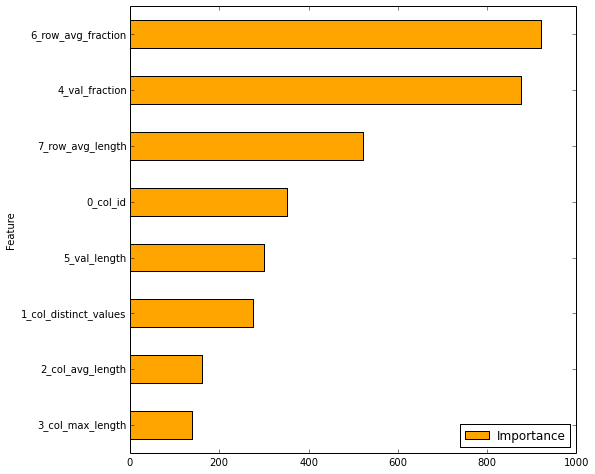

In [74]:
%matplotlib inline  
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

train size: 8best params: {'colsample_bytree': 0.8, 'min_child_weight': 1, 'subsample': 0.8, 'eta': 0.1, 'objective': 'binary:logistic', 'seed': 0, 'max_depth': 3}
(1131672, 15)
(96, 15)
(1131672, 15)
1 - F-Score: 0.856209017641
1 - Precision: 0.832816229411
1 - Recall: 0.880953935087


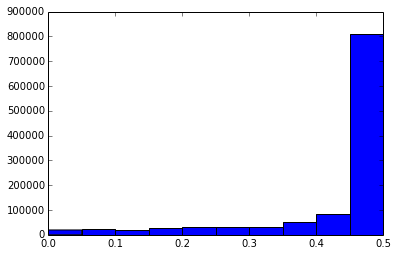

196
196
2 - F-Score: 0.822315242863
2 - Precision: 0.805219471547
2 - Recall: 0.840152688099


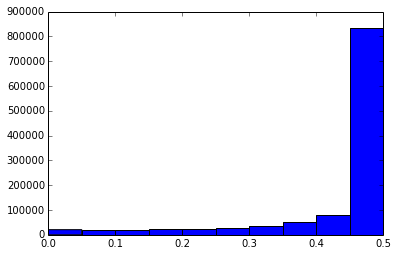

296
296
2 - F-Score: 0.864649891333
2 - Precision: 0.847587400311
2 - Recall: 0.882413453681


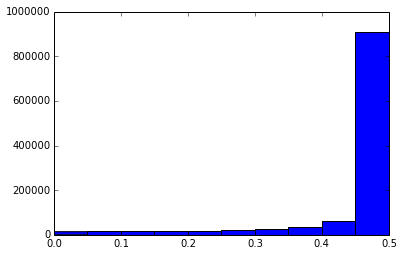

396
396
2 - F-Score: 0.898607487466
2 - Precision: 0.85534387889
2 - Recall: 0.946480836965


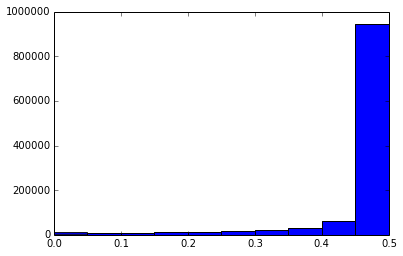

496
496
2 - F-Score: 0.912982638119
2 - Precision: 0.8775431076
2 - Recall: 0.951405080378


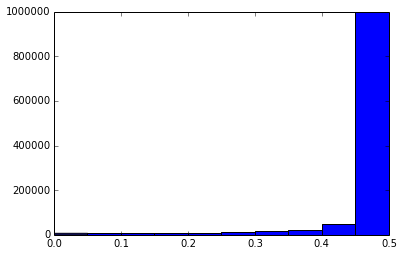

596
596
2 - F-Score: 0.928010882859
2 - Precision: 0.888900843261
2 - Recall: 0.970720855972


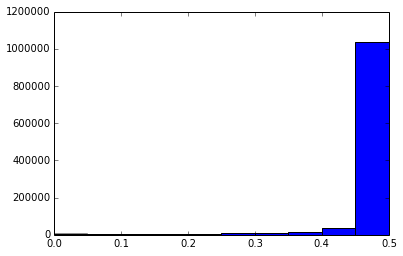

696
696
2 - F-Score: 0.931551662069
2 - Precision: 0.896443004543
2 - Recall: 0.969522431939


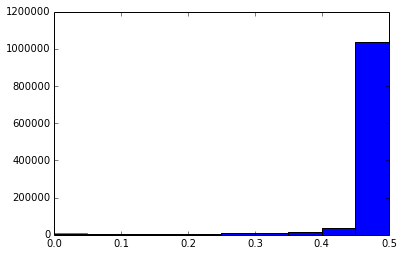

796
796
2 - F-Score: 0.938572273589
2 - Precision: 0.907799843857
2 - Recall: 0.971504139654


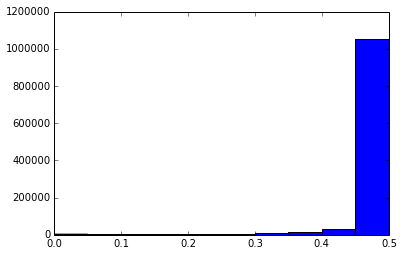

896
896
2 - F-Score: 0.941548287606
2 - Precision: 0.916829116241
2 - Recall: 0.967637329212


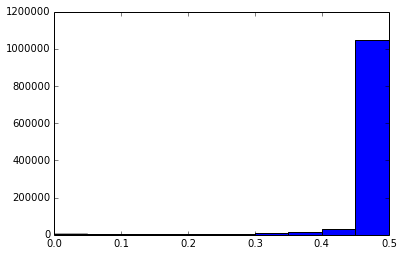

996
996
2 - F-Score: 0.950891676742
2 - Precision: 0.935181561813
2 - Recall: 0.967138638601
F-Score: [0.95089167674247266]
Precision: [0.93518156181281575]
Recall: [0.96713863860074201]


In [60]:
f_scores = []
precision_scores = []
recall_scores = []

models = dict()

n = 1
for train_size in [8]:
    f_current = 0.0
    precision_current = 0.0
    recall_current = 0.0
    
    our_params = {'eta': 0.1, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8,
                          'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}

    '''
    train, train_target, test, test_target = create_data(feature_matrix, train_size)
    xgdmat = xgb.DMatrix(train, train_target, feature_names=total_schema)

    cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
    ind_params = {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
         'objective': 'binary:logistic'}

    optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                        cv_params, 
                         scoring = 'f1', cv = 5, n_jobs = 4) 

    optimized_GBM.fit(train, train_target)

    print "best scores: " + str(optimized_GBM.grid_scores_)

    our_params = optimized_GBM.best_params_
    '''
    
    print "train size: " + str(train_size) + "best params: " + str(our_params)
    
    for t in range(n):
        print feature_matrix.shape
        
        #train, train_target, test, test_target = create_data(feature_matrix, train_size)
        train, train_target = create_data_smart(feature_matrix, column_features, schema_tools, train_size)
        
        print feature_matrix.shape
        
        xgdmat = xgb.DMatrix(train, train_target, feature_names=total_schema)
 
        final_gb = xgb.train(our_params, xgdmat, num_boost_round=3000)

        testdmat = xgb.DMatrix(feature_matrix, feature_names=total_schema)
        y_pred = final_gb.predict(testdmat)

        #res = (y_pred > 0.5)
                
        print "1 - F-Score: " + str(f1_score(target, res))
        print "1 - Precision: " + str(precision_score(target, res))
        print "1 - Recall: " + str(recall_score(target, res))
        
        
        for r in range (9):
            train, train_target = create_next_data(train, train_target,feature_matrix, target, y_pred, 100)

            print len(train)
            print len(train_target)
            xgdmat2 = xgb.DMatrix(train, train_target, feature_names=total_schema)

            final_gb2 = xgb.train(our_params, xgdmat2, num_boost_round=3000)

            y_pred = final_gb2.predict(testdmat)

            res2 = (y_pred > 0.5)

            print "2 - F-Score: " + str(f1_score(target, res2))
            print "2 - Precision: " + str(precision_score(target, res2))
            print "2 - Recall: " + str(recall_score(target, res2))
                
        f_current += f1_score(target, res2)
        precision_current += precision_score(target, res2)
        recall_current += recall_score(target, res2)
    
    f_scores.append(f_current / n)
    precision_scores.append(precision_current / n)
    recall_scores.append(recall_current / n)

print "F-Score: " + str(f_scores)
print "Precision: " + str(precision_scores)
print "Recall: " + str(recall_scores)

In [24]:
f_scores = []
precision_scores = []
recall_scores = []

n = 5
for train_size in [2, 5, 10, 15, 100, 1000, 10000, 100000, 200000]:
    f_current = 0.0
    precision_current = 0.0
    recall_current = 0.0
    for t in range(n):
        train, train_target, test, test_target = create_data(feature_matrix, train_size)

        gnb = GaussianNB()
        final = gnb.fit(train, train_target)

        res = final.predict(test)
        
        f_current += f1_score(test_target, res)
        precision_current += precision_score(test_target, res)
        recall_current += recall_score(test_target, res)
    
    f_scores.append(f_current / n)
    precision_scores.append(precision_current / n)
    recall_scores.append(recall_current / n)

print "F-Score: " + str(f_scores)
print "Precision: " + str(precision_scores)
print "Recall: " + str(recall_scores)

F-Score: [0.1890476877457227, 0.37834691631269701, 0.58013839104177711, 0.64066265622150431, 0.76637150886752126, 0.88541243966779748, 0.8904424312141298, 0.89418077951191766, 0.89400388396576158]
Precision: [0.12948940111400137, 0.62960554503886479, 0.70424754442742199, 0.64042826713778922, 0.807455474301358, 0.90216814718046978, 0.89283842140448699, 0.89833355466123843, 0.89884032575999573]
Recall: [0.35217309570185013, 0.34439729061364038, 0.55682396832813552, 0.65127321356131895, 0.75088111053690398, 0.86981633402841962, 0.88823521575000952, 0.89007312570900476, 0.88922014444919262]


In [25]:
f_scores = []
precision_scores = []
recall_scores = []

n = 5
for train_size in [30,100,1000,10000,30000,100000]:
    f_current = 0.0
    precision_current = 0.0
    recall_current = 0.0
    
    for t in range(n):
        train, train_target, test, test_target = create_data(feature_matrix, train_size)

        logistic = linear_model.LogisticRegression()
        final = logistic.fit(train, train_target)

        res = final.predict(test)
        
        f_current += f1_score(test_target, res)
        precision_current += precision_score(test_target, res)
        recall_current += recall_score(test_target, res)
    
    f_scores.append(f_current / n)
    precision_scores.append(precision_current / n)
    recall_scores.append(recall_current / n)

print "F-Score: " + str(f_scores)
print "Precision: " + str(precision_scores)
print "Recall: " + str(recall_scores)

F-Score: [0.87223511722492031, 0.89280466393892388, 0.9687255651065676, 0.95227522685165267, 0.95391058569075116, 0.95623387247360725]
Precision: [0.93076489020254838, 0.90334381529741548, 0.99457415845025388, 0.9703945073953697, 0.97138393496406006, 0.97921391826144721]
Recall: [0.84483747697020684, 0.88643684568142933, 0.94420199829901663, 0.93495260626051502, 0.93739386301633743, 0.93440290289820849]


In [145]:
recall = recall_score(test_target, res)
print "recall: " + str(recall)

recall: 0.931965062081


In [146]:
precision = precision_score(test_target, res)
print "precision: " + str(precision)

precision: 0.963111878677


In [99]:
column_detect = np.array([False] * len(clean) * len(clean.columns))
target = np.array([False] * len(clean) * len(clean.columns))

In [100]:
i = 0
for row in range(len(clean)):
    for column in range(len(clean.columns)):
        column_detect[i] = (row, column) in error_sets[4]
        target[i] = ground_truth[row,column]
        i += 1

In [101]:
TP = np.sum(np.logical_and(column_detect == True, target == True))

In [102]:
FP = np.sum(np.logical_and(column_detect == True, target == False))

In [103]:
FN = np.sum(np.logical_and(column_detect == False, target == True))

In [104]:
print "precision: " + str(float(TP) / (TP + FP))

precision: 0.999349493101


In [105]:
print "recall: " + str(float(TP) / (TP + FN))

recall: 0.946619217082
